In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 

import cptac
import cptac.utils as u

In [2]:
c1 = cptac.Gbm()
c2 = cptac.Endometrial()

In [3]:
cancer1 = "GBM"
cancer2 = "Endometrial"
gene = 'PTEN'

In [4]:
#GBM ttest
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
prot = c1.get_proteomics()
prot_list = list(prot.columns)
prot_and_mutations = c1.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = prot_list)  

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')

In [5]:
col_list = list(mut_status.columns)
col_list.remove('binary_mutations')

print("Doing t-test comparisons for GBM\n")

# Call wrap_ttest, pass in formatted dataframe
wrap_results = u.wrap_ttest(mut_status, 'binary_mutations', col_list, return_all=True)

Doing t-test comparisons for GBM



C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


No significant comparisons.


In [6]:
wrap_results.loc[wrap_results['Comparison'] == gene+"_proteomics"]

,Comparison,P_Value
0,PTEN_proteomics,0.000032


In [7]:
# endo ttest
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
prot2 = c2.get_proteomics()
prot_list2 = list(prot2.columns)
prot_and_mutations = c2.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = prot_list2)  

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status2 = mut_status.dropna(axis=1,how='all')

In [8]:
col_list2 = list(mut_status2.columns)
col_list2.remove('binary_mutations')

print("Doing t-test comparisons for cancer 2\n")

# Call wrap_ttest, pass in formatted dataframe
wrap_results2 = u.wrap_ttest(mut_status2, 'binary_mutations', col_list2, return_all=True)

Doing t-test comparisons for cancer 2

78 significant comparisons!


In [9]:
wrap_results2.loc[wrap_results2['Comparison'] == gene+"_proteomics"]

,Comparison,P_Value
7303,PTEN_proteomics,0.018255


In [10]:
#combine pval results
combined = wrap_results.merge(wrap_results2, on='Comparison')
combined = combined.replace(regex=True,to_replace='_proteomics', value='')

In [11]:
# Green = interacting protein
interacting_list = u.get_interacting_proteins(gene)
combined["color"] = np.where(combined["Comparison"].isin(interacting_list), "green", "black")
print(interacting_list)
#combined.loc[combined['color'] == 'green']

['MDM2', 'CSNK2A1', 'PDGFRB', 'PIK3R2', 'PIK3C3', 'CSNK2A2', 'SLC9A3R1', 'PIK3R3', 'USP13', 'PIK3CA', 'TP53', 'EGFR', 'PIK3CB', 'PTK2', 'USP7', 'XIAP', 'PTEN', 'PREX2', 'MAST2', 'PIK3CD', 'ROCK1', 'SHC1', 'NEDD4', 'INPP4B', 'PIK3R1', 'AKT1', 'MVP', 'MAGI3']


In [12]:
limit_x = combined.loc[combined['P_Value_x'] <= 1]
limit_y = combined.loc[combined['P_Value_y'] <= 1]
limit_both = limit_x.loc[limit_x['P_Value_y'] <= 1]
limit_both.loc[limit_both['color'] == 'green']

,Comparison,P_Value_x,P_Value_y,color
0,PTEN,0.000032,0.018255,green
1402,AKT1,0.459782,0.624563,green
2657,MAST2,0.924247,0.662951,green
2741,EGFR,0.957755,0.019946,green
3375,CSNK2A2,0.283557,0.014752,green
3497,CSNK2A1,0.437763,0.000102,green
4607,INPP4B,0.637890,0.255707,green
4757,MAGI3,0.733045,0.536579,green
5660,ROCK1,0.556804,0.542352,green
6046,PTK2,0.818450,0.368757,green


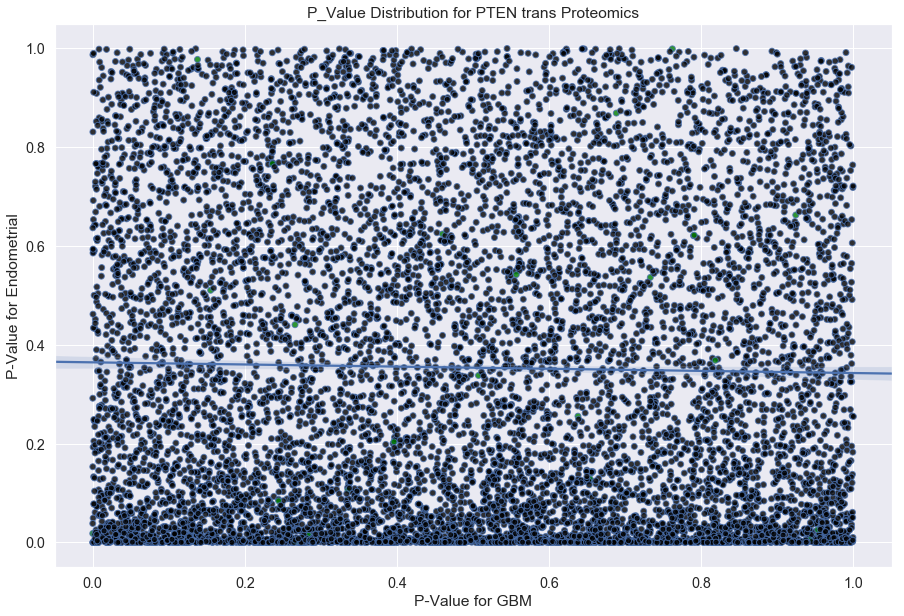

In [13]:
# Format figure size and font
plt.rcParams['figure.figsize']=(15,10)
sns.set(font_scale = 1.3)

# Format title and axis
plot = sns.regplot(x="P_Value_x", y="P_Value_y", data=limit_both, scatter_kws={'facecolors':limit_both['color']})
plot.set_title("P_Value Distribution for "+gene+" trans Proteomics")
plot.set(xlabel = 'P-Value for '+cancer1)
plot.set(ylabel = 'P-Value for '+cancer2)

plt.show()
plt.clf()
plt.close()